In [2]:
%pylab inline
import pandas as pd
import scipy.sparse as sparse
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

Populating the interactive namespace from numpy and matplotlib


In [3]:
# DATA PLUGGIN

raw_train = pd.read_csv("train_data.csv.gz", compression="gzip", encoding="utf8")
train_data = raw_train.copy()
print("Train data shape : ", train_data.values.shape)

raw_test = pd.read_csv("test_data.csv.gz", compression="gzip", encoding="utf8")
test_data = raw_test.copy()
print("Test data shape : ", test_data.values.shape)

raw_t_target = pd.read_csv("train_target.csv")
train_target = raw_t_target.copy()
print("Train target shape : ", train_target.values.shape)


Train data shape :  (296042, 4)
Test data shape :  (1107946, 4)
Train target shape :  (5000, 2)


In [4]:
full_data = pd.concat([train_data,test_data])

In [5]:
subreddit      = full_data.subreddit.unique()
subreddit_size = subreddit.shape[0]

#prima era values!
subreddit_index = array(range(subreddit_size))

subreddit_bij = dict( zip(subreddit, subreddit_index) )

In [6]:
train_subreddit      = train_data.subreddit.unique()
train_subreddit_size = train_subreddit.shape[0]

train_subreddit_index = []

for train_arg in train_subreddit:
    train_subreddit_index.append( subreddit_bij[train_arg] )

train_reddit_bij = dict( zip(train_subreddit, train_subreddit_index) )

In [7]:
test_subreddit      = test_data.subreddit.unique()
test_subreddit_size = test_subreddit.shape[0]

test_subreddit_index = []

for test_arg in test_subreddit:
    test_subreddit_index.append( subreddit_bij[test_arg] )
    
test_reddit_bij = dict( zip(test_subreddit, test_subreddit_index) )

In [8]:
author      = full_data.author.unique()
population_size = author.shape[0]

#prima era values!
author_index = array(range(population_size))

author_bij = dict( zip(author, author_index) )

In [9]:
train_author      = train_data.author.unique()
train_population_size = train_author.shape[0]

train_author_index = []

for train_arg in train_author:
    train_author_index.append( author_bij[train_arg] )

train_author_bij = dict( zip(train_author, train_author_index) )

In [10]:
test_author      = test_data.author.unique()
test_population_size = test_author.shape[0]

test_author_index = []

for test_arg in test_author:
    test_author_index.append( author_bij[test_arg] )
    
test_author_bij = dict( zip(test_author, test_author_index) )

In [11]:
# TARGET PREPROCESSING

# quello che faccio qui è sistemare l'ordine in cui incorrono i target a seconda dell autore
# dai dati il mio ordine è dato da train_data.author.unique()
# ho già la mia biiezione per l'ordine, che mi da l'identificativo dell autore
# aggiungo una colonna con il risultato al dataframe e la ordino secondo quesa nuova colonna
# rimuovo la colonna

print("UNSORTED:")

print(train_target.head(),"\n")

target_author = train_target.values[:,0]

identities = zeros(train_population_size)

for k in range(train_population_size):
    identities[k]=train_author_bij[target_author[k]]
    
train_target['user_id'] = identities
train_target = train_target.sort_values(by=['user_id'])
train_target = train_target.drop(['user_id'],axis=1)

print("SORTED:")

print(train_target.head())

gender_target = train_target.values[:,1]

print()
print(type(gender_target))
print(gender_target.shape)
print(gender_target[0:5])

UNSORTED:
            author  gender
0     RedThunder90       0
1          Lirkmor       1
2           In0chi       0
3    ProjectGrudge       0
4  TehTurtleHermit       0 

SORTED:
             author  gender
3806    Shamus_Aran       0
2930       Riddance       1
3583  Secret_Wizard       0
2359   Penultimatum       0
1909      7-SE7EN-7       0

<class 'numpy.ndarray'>
(5000,)
[0 1 0 0 0]


In [12]:
# FEATURE 1 : USER SPEECH
# voglio un dataframe con il nome dello user
# e un testo dove raccolgo tutti i suoi commenti
# da trasformare con tdidf in un vettore di frequenze
# poi gli applico quella distanza funzionale che ho scritto sotto

# --------------------------- FULL TEXT ---------------------------

comments_collection = full_data.drop(['subreddit','created_utc'],axis=1).values

author_corpus = [''] * population_size

for a in comments_collection:

    l = author_bij[a[0]]
    
    text = a[1]
    
    if(type(text)!=str):
        text=str(text)
    
    author_corpus[l]+=(" "+text)

In [13]:
cv = CountVectorizer( max_df=0.90, min_df= 0.00001,
                      stop_words= 'english' , max_features=20000)

C = cv.fit_transform(author_corpus)

tfidf = TfidfTransformer()
# full_tfidf = tfidf.fit_transform(C) ---> RUN THIS LINE !!!!

full_tfidf = tfidf.fit_transform(C)

In [14]:
print("full_tfidf is a sparse matrix with shape: %s" % str(full_tfidf.shape))

full_tfidf is a sparse matrix with shape: (20000, 20000)


In [15]:
# --- I N T E R E S T S   A N D   S U B R E D D I T S ---

# --- posso creare una matrice 'sparsa' in cui vedo chi partecipa e quanto a quale discussione
# devo mappare il sub_dataframe con utente e subr di ciascun commento nella matrice di attività

#qui mi tengo autore del commento e subreddit del commento, ma solo del train set
interests_collection = full_data.drop(['created_utc','body'],axis=1).values

print("train_interests.shape:",interests_collection.shape)

train_interests.shape: (1403988, 2)


In [16]:
interests_matrix = zeros(population_size*subreddit_size)
interests_matrix = interests_matrix.reshape(population_size,subreddit_size)

for j in interests_collection:
    
    k = author_bij[j[0]]
    l = subreddit_bij[j[1]]
    interests_matrix[k,l]+=1

print("interests_matrix.shape:",interests_matrix.shape)

interests_matrix.shape: (20000, 4033)


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# --------------------------- TEXT TRAIN-TEST SPLIT ---------------------------

from sklearn.model_selection import train_test_split

# qua aggiusta gli indici
train_text_tfidf = full_tfidf[0:5000]
test_text_tfidf  = full_tfidf[5000:]


SEED = 2000
train_text_X , valid_text_X, train_text_Y , valid_text_Y = train_test_split( train_text_tfidf, gender_target,
                                                                             test_size = 0.15,  random_state = SEED)

train_text_Y = train_text_Y.astype('int')
valid_text_Y = valid_text_Y.astype('int')

print(train_text_X.shape,valid_text_X.shape)
print(train_text_Y.shape,valid_text_Y.shape)

(4250, 20000) (750, 20000)
(4250,) (750,)


In [19]:
# SE USO LO STESSO RANDOM STATE DOVREI AVERE GLI STESSI RIMESCOLAMENTI

# --------------------------- REDDIT TRAIN-TEST SPLIT ---------------------------

train_interests = interests_matrix[0:5000]
test_interests  = interests_matrix[5000:]

SEED = 2000
train_redd_X , valid_redd_X, train_redd_Y , valid_redd_Y = train_test_split( train_interests, gender_target, 
                                                                                 test_size = 0.15, random_state = SEED)

train_redd_Y = train_redd_Y.astype('int')
valid_redd_Y = valid_redd_Y.astype('int')

print(train_redd_X.shape,valid_redd_X.shape)
print(train_redd_Y.shape,valid_redd_Y.shape)

(4250, 4033) (750, 4033)
(4250,) (750,)


In [20]:
# M O D E L , F I T , E C C 

In [21]:
from sklearn.neural_network import MLPClassifier

In [21]:
alpha_0, alpha_1, alpha_2 = alpha[0],alpha[1],alpha[2]
print(alpha_0,alpha_1,alpha_2)
hu_0, hu_1, hu_2, hu_3 = text_hidden_units[0], text_hidden_units[1], text_hidden_units[2], text_hidden_units[3]
print(hu_0,hu_1,hu_2,hu_3)
hl_0, hl_1, hl_2 = text_hidden_layers[0], text_hidden_layers[1], text_hidden_layers[2]
print(hl_0,hl_1,hl_2)

0.001 0.01 0.1
1000.0 2000.0 3000.0 4000.0
2.0 3.0 4.0


In [22]:
text_hp = len(alpha)*len(text_hidden_units)*len(text_hidden_layers)

text_params = zeros(text_hp*3).reshape(text_hp,3)
text_scores = []

j=0

In [55]:
print(logspace(-3.5,-2.2,6))

[0.00031623 0.00057544 0.00104713 0.00190546 0.00346737 0.00630957]


Iteration 1, loss = 0.80977389
Validation score: 0.381176
Iteration 2, loss = 0.69613173
Validation score: 0.630588
Iteration 3, loss = 0.62672538
Validation score: 0.727059
Iteration 4, loss = 0.58395007
Validation score: 0.748235
Iteration 5, loss = 0.53462157
Validation score: 0.769412
Iteration 6, loss = 0.46617469
Validation score: 0.821176
Iteration 7, loss = 0.37491731
Validation score: 0.849412
Iteration 8, loss = 0.29220011
Validation score: 0.863529
Iteration 9, loss = 0.21932394
Validation score: 0.858824
Iteration 10, loss = 0.15725298
Validation score: 0.863529
Iteration 11, loss = 0.10839560
Validation score: 0.861176
Iteration 12, loss = 0.07333279
Validation score: 0.856471
Iteration 13, loss = 0.05097636
Validation score: 0.858824
Iteration 14, loss = 0.03630975
Validation score: 0.854118
Iteration 15, loss = 0.02704951
Validation score: 0.856471
Iteration 16, loss = 0.02078070
Validation score: 0.854118
Iteration 17, loss = 0.01607068
Validation score: 0.854118
Iterat

Iteration 11, loss = 0.29139528
Validation score: 0.847059
Iteration 12, loss = 0.24394879
Validation score: 0.851765
Iteration 13, loss = 0.20642715
Validation score: 0.851765
Iteration 14, loss = 0.17616793
Validation score: 0.851765
Iteration 15, loss = 0.15308983
Validation score: 0.844706
Iteration 16, loss = 0.13561800
Validation score: 0.842353
Iteration 17, loss = 0.12165314
Validation score: 0.837647
Iteration 18, loss = 0.11029483
Validation score: 0.835294
Iteration 19, loss = 0.10115832
Validation score: 0.830588
Iteration 20, loss = 0.09343612
Validation score: 0.840000
Iteration 21, loss = 0.08681370
Validation score: 0.835294
Iteration 22, loss = 0.08116370
Validation score: 0.837647
Iteration 23, loss = 0.07614631
Validation score: 0.840000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
[0.8413333333333334, 0.84, 0.84, 0.84, 0.8453333333333334, 0.848, 0.8493333333333334]
Iteration 1, loss = 0.84913701
Validation score: 0.331

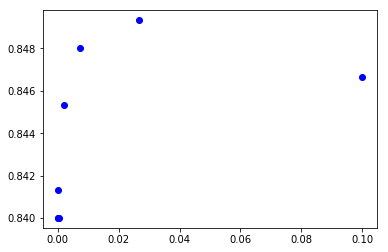

In [32]:
# --------------- hu = 0.15k, hl = 4 ---------------

h_l, h_u = 4, 150
h4alpha = logspace(-5,-1,8)
alpha_h4_score = []

for a in h4alpha:
    text_perceptron = MLPClassifier(solver='adam', activation= 'relu',alpha = a,
                                    hidden_layer_sizes=(int(h_u), int(h_l)), random_state=1, 
                                    learning_rate = 'invscaling', max_iter = 400,
                                    verbose=True,early_stopping=True)
    
    text_perceptron.fit(train_text_X, train_text_Y)

    sred = text_perceptron.score(valid_text_X,valid_text_Y)
    alpha_h4_score.append( sred )
    print(alpha_h4_score)
    
win = argmax(alpha_h4_score)
print(win,alpha_h4_score[win])
print("Best alpha:",h4alpha[win])

plot(h4alpha,alpha_h4_score,'bo')

In [33]:
winh4 = argmax(alpha_h4_score)
best_alpha_h4 = h4alpha[win]
print(best_alpha_h4)
best_alpha_h4 = 0.026826957952797246

0.026826957952797246


In [35]:
h4alpha = linspace(0.026826957952797246-0.002,0.026826957952797246+0.04,num=8)
print(h4alpha)

[0.02482696 0.03082696 0.03682696 0.04282696 0.04882696 0.05482696
 0.06082696 0.06682696]


In [44]:
print(linspace(0.09-0.005,0.09+0.005,num=4))

[0.085      0.08833333 0.09166667 0.095     ]


In [43]:
h_l, h_u = 4, 150
h4alpha = linspace(0.09-0.005,0.09+0.005,num=4)
alpha_h4_score = []

for a in h4alpha:
    text_perceptron = MLPClassifier(solver='adam', activation= 'relu',alpha = a,
                                    hidden_layer_sizes=(int(h_u), int(h_l)), random_state=1, 
                                    learning_rate = 'invscaling', max_iter = 400,
                                    verbose=True,early_stopping=True)
    
    text_perceptron.fit(train_text_X, train_text_Y)

    sred = text_perceptron.score(valid_text_X,valid_text_Y)
    alpha_h4_score.append( sred )
    print(alpha_h4_score)

Iteration 1, loss = 0.84449863
Validation score: 0.341176
Iteration 2, loss = 0.72747111
Validation score: 0.600000
Iteration 3, loss = 0.66619345
Validation score: 0.727059
Iteration 4, loss = 0.63010305
Validation score: 0.741176
Iteration 5, loss = 0.60059628
Validation score: 0.745882
Iteration 6, loss = 0.57258542
Validation score: 0.750588
Iteration 7, loss = 0.54069499
Validation score: 0.771765
Iteration 8, loss = 0.50403186
Validation score: 0.804706
Iteration 9, loss = 0.46641181
Validation score: 0.814118
Iteration 10, loss = 0.42968235
Validation score: 0.832941
Iteration 11, loss = 0.38944786
Validation score: 0.832941
Iteration 12, loss = 0.35056203
Validation score: 0.840000
Iteration 13, loss = 0.31594382
Validation score: 0.842353
Iteration 14, loss = 0.28385296
Validation score: 0.842353
Iteration 15, loss = 0.25597627
Validation score: 0.840000
Iteration 16, loss = 0.23199028
Validation score: 0.837647
Iteration 17, loss = 0.21193973
Validation score: 0.830588
Iterat

7 0.8546666666666667
Best alpha: 0.09
0.09


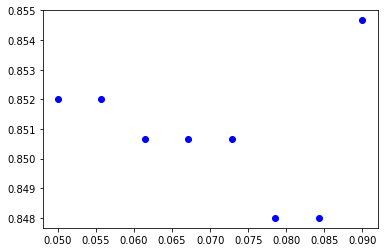

In [40]:
win = argmax(alpha_h4_score)
print(win,alpha_h4_score[win])
print("Best alpha:",h4alpha[win])

plot(h4alpha,alpha_h4_score,'bo')
best_alpha_h4 = h4alpha[win]
print(best_alpha_h4)

In [ ]:
# il modello hl = 4 , hu = 150, a = 0.09
# ottiene validation score = 0.85466666666666
# ma mettendolo assieme al modello de reddit da risultati inferiori a quello sotto

In [ ]:
# alphah4_2 = 0.054826957952797246 score = 0.8506666666666667
# alphah4_2 = 0.09                 score = 0.8546666666666667 hL = 4, h_u = 150

In [42]:
# -------------------------------------------------------------------------------------------------
# ----------------------------------------- REDDIT PERCEPTRON -------------------------------------
# -------------------------------------------------------------------------------------------------

# DO MODEL SELECTION 
alpha = logspace(-5,0,5)
redd_hidden_units = linspace(15,35,num=3)
redd_hidden_layers =  linspace(3,4,num=2)

hp = len(redd_hidden_units)*len(redd_hidden_layers)*len(alpha)
print(hp)

30


In [43]:
params = zeros(hp*3).reshape(hp,3)

redd_scores = []

j=0
for h_l in redd_hidden_layers:
    for h_u in redd_hidden_units:
        for a in alpha:
    
            redd_perceptron = MLPClassifier(solver='adam', activation= 'relu',alpha = a,
                                            hidden_layer_sizes=(int(h_u), int(h_l)), random_state=1, 
                                            learning_rate = 'invscaling', max_iter = 400,
                                            verbose=True,early_stopping=True)
    
            redd_perceptron.fit(train_redd_X, train_redd_Y)
            sred = redd_perceptron.score(valid_redd_X,valid_redd_Y)
            redd_scores.append( sred )
        
            params[j,0], params[j,1], params[j,2] = h_l, h_u, a
            j = j + 1

Iteration 1, loss = 0.92618104
Validation score: 0.343529
Iteration 2, loss = 0.83655430
Validation score: 0.400000
Iteration 3, loss = 0.76665172
Validation score: 0.444706
Iteration 4, loss = 0.70652414
Validation score: 0.498824
Iteration 5, loss = 0.65011746
Validation score: 0.520000
Iteration 6, loss = 0.59704693
Validation score: 0.560000
Iteration 7, loss = 0.54910165
Validation score: 0.604706
Iteration 8, loss = 0.50752644
Validation score: 0.642353
Iteration 9, loss = 0.46852917
Validation score: 0.677647
Iteration 10, loss = 0.43537476
Validation score: 0.727059
Iteration 11, loss = 0.40509330
Validation score: 0.760000
Iteration 12, loss = 0.38097541
Validation score: 0.804706
Iteration 13, loss = 0.35908415
Validation score: 0.818824
Iteration 14, loss = 0.34143260
Validation score: 0.816471
Iteration 15, loss = 0.32666244
Validation score: 0.807059
Iteration 16, loss = 0.31355662
Validation score: 0.804706
Iteration 17, loss = 0.30329510
Validation score: 0.797647
Iterat

Iteration 1, loss = 0.58419672
Validation score: 0.710588
Iteration 2, loss = 0.50400721
Validation score: 0.710588
Iteration 3, loss = 0.47088910
Validation score: 0.710588
Iteration 4, loss = 0.44691441
Validation score: 0.710588
Iteration 5, loss = 0.42922389
Validation score: 0.710588
Iteration 6, loss = 0.41344269
Validation score: 0.710588
Iteration 7, loss = 0.39981818
Validation score: 0.710588
Iteration 8, loss = 0.38882149
Validation score: 0.710588
Iteration 9, loss = 0.37830203
Validation score: 0.710588
Iteration 10, loss = 0.36842733
Validation score: 0.710588
Iteration 11, loss = 0.35942911
Validation score: 0.710588
Iteration 12, loss = 0.35050219
Validation score: 0.710588
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.58332831
Validation score: 0.710588
Iteration 2, loss = 0.50298732
Validation score: 0.710588
Iteration 3, loss = 0.47018903
Validation score: 0.710588
Iteration 4, loss = 0.44645414
Val

Iteration 7, loss = 0.30958229
Validation score: 0.832941
Iteration 8, loss = 0.28990927
Validation score: 0.844706
Iteration 9, loss = 0.27495746
Validation score: 0.842353
Iteration 10, loss = 0.26342878
Validation score: 0.849412
Iteration 11, loss = 0.24986809
Validation score: 0.840000
Iteration 12, loss = 0.23924823
Validation score: 0.842353
Iteration 13, loss = 0.22954784
Validation score: 0.847059
Iteration 14, loss = 0.22073083
Validation score: 0.847059
Iteration 15, loss = 0.21320560
Validation score: 0.842353
Iteration 16, loss = 0.20721239
Validation score: 0.851765
Iteration 17, loss = 0.19963356
Validation score: 0.840000
Iteration 18, loss = 0.19384676
Validation score: 0.842353
Iteration 19, loss = 0.18927237
Validation score: 0.840000
Iteration 20, loss = 0.18495047
Validation score: 0.847059
Iteration 21, loss = 0.17960117
Validation score: 0.835294
Iteration 22, loss = 0.17594392
Validation score: 0.840000
Iteration 23, loss = 0.17307711
Validation score: 0.837647


Iteration 1, loss = 0.91717403
Validation score: 0.261176
Iteration 2, loss = 0.80590933
Validation score: 0.277647
Iteration 3, loss = 0.76031776
Validation score: 0.425882
Iteration 4, loss = 0.66830245
Validation score: 0.576471
Iteration 5, loss = 0.57666383
Validation score: 0.724706
Iteration 6, loss = 0.51568279
Validation score: 0.811765
Iteration 7, loss = 0.47183916
Validation score: 0.854118
Iteration 8, loss = 0.43918449
Validation score: 0.840000
Iteration 9, loss = 0.41704283
Validation score: 0.828235
Iteration 10, loss = 0.39925410
Validation score: 0.818824
Iteration 11, loss = 0.38362951
Validation score: 0.821176
Iteration 12, loss = 0.37172771
Validation score: 0.818824
Iteration 13, loss = 0.36139802
Validation score: 0.821176
Iteration 14, loss = 0.35407173
Validation score: 0.821176
Iteration 15, loss = 0.34703359
Validation score: 0.809412
Iteration 16, loss = 0.33948641
Validation score: 0.823529
Iteration 17, loss = 0.33383872
Validation score: 0.821176
Iterat

Iteration 10, loss = 0.24894877
Validation score: 0.830588
Iteration 11, loss = 0.23111363
Validation score: 0.832941
Iteration 12, loss = 0.21754416
Validation score: 0.832941
Iteration 13, loss = 0.20721332
Validation score: 0.840000
Iteration 14, loss = 0.19732253
Validation score: 0.842353
Iteration 15, loss = 0.18767363
Validation score: 0.847059
Iteration 16, loss = 0.17920158
Validation score: 0.844706
Iteration 17, loss = 0.17180753
Validation score: 0.844706
Iteration 18, loss = 0.16544138
Validation score: 0.842353
Iteration 19, loss = 0.15912117
Validation score: 0.844706
Iteration 20, loss = 0.15350526
Validation score: 0.842353
Iteration 21, loss = 0.14819903
Validation score: 0.840000
Iteration 22, loss = 0.14460320
Validation score: 0.837647
Iteration 23, loss = 0.13992700
Validation score: 0.835294
Iteration 24, loss = 0.13622504
Validation score: 0.835294
Iteration 25, loss = 0.13230357
Validation score: 0.832941
Iteration 26, loss = 0.12860717
Validation score: 0.8305

Iteration 36, loss = 0.26539499
Validation score: 0.840000
Iteration 37, loss = 0.25977314
Validation score: 0.825882
Iteration 38, loss = 0.25979514
Validation score: 0.832941
Iteration 39, loss = 0.26042514
Validation score: 0.832941
Iteration 40, loss = 0.25817856
Validation score: 0.832941
Iteration 41, loss = 0.27033018
Validation score: 0.828235
Iteration 42, loss = 0.25911887
Validation score: 0.832941
Iteration 43, loss = 0.25584626
Validation score: 0.825882
Iteration 44, loss = 0.25374412
Validation score: 0.832941
Iteration 45, loss = 0.25180617
Validation score: 0.832941
Iteration 46, loss = 0.24886274
Validation score: 0.830588
Iteration 47, loss = 0.24972147
Validation score: 0.830588
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [44]:
win = argmax(redd_scores)
print( argmax(redd_scores))
print( max(redd_scores))
print(params[win])

24
0.856
[ 4. 25.  1.]


In [46]:
a_redd_scores = []
redd_alpha = logspace(-5,1,20)

for a in redd_alpha:
    
        redd_perceptron = MLPClassifier(solver='adam', activation= 'relu',alpha = a,
                                            hidden_layer_sizes=(25, 4), random_state=1, 
                                            learning_rate = 'invscaling', max_iter = 400,
                                            verbose=True,early_stopping=True)
    
        redd_perceptron.fit(train_redd_X, train_redd_Y)
        sred = redd_perceptron.score(valid_redd_X,valid_redd_Y)
        a_redd_scores.append( sred )

Iteration 1, loss = 0.97468447
Validation score: 0.468235
Iteration 2, loss = 0.76757248
Validation score: 0.552941
Iteration 3, loss = 0.64576863
Validation score: 0.607059
Iteration 4, loss = 0.54400757
Validation score: 0.668235
Iteration 5, loss = 0.46244709
Validation score: 0.729412
Iteration 6, loss = 0.39889963
Validation score: 0.748235
Iteration 7, loss = 0.35053934
Validation score: 0.785882
Iteration 8, loss = 0.31337295
Validation score: 0.811765
Iteration 9, loss = 0.28484457
Validation score: 0.818824
Iteration 10, loss = 0.26136995
Validation score: 0.818824
Iteration 11, loss = 0.24484131
Validation score: 0.816471
Iteration 12, loss = 0.22994099
Validation score: 0.804706
Iteration 13, loss = 0.21795158
Validation score: 0.811765
Iteration 14, loss = 0.20708022
Validation score: 0.790588
Iteration 15, loss = 0.19808341
Validation score: 0.807059
Iteration 16, loss = 0.18948269
Validation score: 0.802353
Iteration 17, loss = 0.18662324
Validation score: 0.802353
Iterat

Iteration 9, loss = 0.28179399
Validation score: 0.816471
Iteration 10, loss = 0.25951518
Validation score: 0.818824
Iteration 11, loss = 0.24378475
Validation score: 0.809412
Iteration 12, loss = 0.22703895
Validation score: 0.809412
Iteration 13, loss = 0.21504565
Validation score: 0.804706
Iteration 14, loss = 0.20545359
Validation score: 0.792941
Iteration 15, loss = 0.19702123
Validation score: 0.800000
Iteration 16, loss = 0.18895635
Validation score: 0.802353
Iteration 17, loss = 0.18473611
Validation score: 0.807059
Iteration 18, loss = 0.17778468
Validation score: 0.800000
Iteration 19, loss = 0.16978388
Validation score: 0.811765
Iteration 20, loss = 0.16414816
Validation score: 0.809412
Iteration 21, loss = 0.15854566
Validation score: 0.807059
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.97336153
Validation score: 0.468235
Iteration 2, loss = 0.76618122
Validation score: 0.560000
Iteration 3, loss = 0.642

Iteration 14, loss = 0.22021241
Validation score: 0.800000
Iteration 15, loss = 0.21265011
Validation score: 0.797647
Iteration 16, loss = 0.20550277
Validation score: 0.802353
Iteration 17, loss = 0.20237358
Validation score: 0.809412
Iteration 18, loss = 0.19540308
Validation score: 0.802353
Iteration 19, loss = 0.18901112
Validation score: 0.811765
Iteration 20, loss = 0.18571379
Validation score: 0.814118
Iteration 21, loss = 0.17928332
Validation score: 0.821176
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.98626286
Validation score: 0.456471
Iteration 2, loss = 0.77446038
Validation score: 0.552941
Iteration 3, loss = 0.65092237
Validation score: 0.614118
Iteration 4, loss = 0.54894083
Validation score: 0.663529
Iteration 5, loss = 0.46995837
Validation score: 0.731765
Iteration 6, loss = 0.40846763
Validation score: 0.750588
Iteration 7, loss = 0.36229761
Validation score: 0.792941
Iteration 8, loss = 0.3277519

Iteration 1, loss = 1.91648329
Validation score: 0.437647
Iteration 2, loss = 1.16966472
Validation score: 0.508235
Iteration 3, loss = 0.98250234
Validation score: 0.562353
Iteration 4, loss = 0.88705674
Validation score: 0.595294
Iteration 5, loss = 0.81938849
Validation score: 0.658824
Iteration 6, loss = 0.76443007
Validation score: 0.680000
Iteration 7, loss = 0.72193091
Validation score: 0.731765
Iteration 8, loss = 0.68506625
Validation score: 0.764706
Iteration 9, loss = 0.65736288
Validation score: 0.797647
Iteration 10, loss = 0.63480261
Validation score: 0.811765
Iteration 11, loss = 0.61540495
Validation score: 0.795294
Iteration 12, loss = 0.59826367
Validation score: 0.792941
Iteration 13, loss = 0.58644586
Validation score: 0.792941
Iteration 14, loss = 0.57433015
Validation score: 0.788235
Iteration 15, loss = 0.56666424
Validation score: 0.795294
Iteration 16, loss = 0.56038171
Validation score: 0.790588
Iteration 17, loss = 0.55424853
Validation score: 0.788235
Iterat

In [23]:
# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------
# FINAL TEXT PERCEPTRON
# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------
a = 0.06898192382366834
hidu = int(5917/10)
hidl = 2
the_text_perceptron = MLPClassifier(solver='adam', activation= 'relu',alpha = 0.09,
                                    hidden_layer_sizes=(hidu, hidl), random_state=1, 
                                    learning_rate = 'invscaling', max_iter = 400,
                                    verbose=True,early_stopping=True)
    
the_text_perceptron.fit(train_text_X, train_text_Y)

text_score = the_text_perceptron.score(valid_text_X,valid_text_Y)
print(text_score)

# il modello hl = 4 , hu = 150, a = 0.09
# ottiene validation score = 0.85466666666666
# ma mettendolo assieme al modello de reddit da risultati inferiori a quello sotto

Iteration 1, loss = 0.66042327
Validation score: 0.727059
Iteration 2, loss = 0.52295064
Validation score: 0.771765
Iteration 3, loss = 0.44929036
Validation score: 0.835294
Iteration 4, loss = 0.38883775
Validation score: 0.828235
Iteration 5, loss = 0.34107944
Validation score: 0.832941
Iteration 6, loss = 0.30037806
Validation score: 0.830588
Iteration 7, loss = 0.27010492
Validation score: 0.828235
Iteration 8, loss = 0.24600395
Validation score: 0.825882
Iteration 9, loss = 0.22819041
Validation score: 0.818824
Iteration 10, loss = 0.21640710
Validation score: 0.823529
Iteration 11, loss = 0.20051550
Validation score: 0.830588
Iteration 12, loss = 0.18738770
Validation score: 0.823529
Iteration 13, loss = 0.17626962
Validation score: 0.823529
Iteration 14, loss = 0.16545061
Validation score: 0.816471
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
0.8266666666666667


In [24]:
# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------
# FINAL REDD PERCEPTRON
# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------


#redd_a = redd_alpha[argmax(a_redd_scores)]
#print( argmax(a_redd_scores),max(a_redd_scores))
#print(redd_a)

hl_redd = 4
hu_redd = 25
redd_a = 4.281332398719396e-05


#plot(redd_alpha,a_redd_scores,'bo',redd_a,max(a_redd_scores),'yo')

the_redd_perceptron = MLPClassifier(solver='adam', activation= 'relu',alpha = redd_a,
                                    hidden_layer_sizes=(hu_redd, hl_redd), random_state=1, 
                                    learning_rate = 'invscaling', max_iter = 400,
                                    verbose=False,early_stopping=True)
    
the_redd_perceptron.fit(train_redd_X, train_redd_Y)

print( the_redd_perceptron.score(valid_redd_X,valid_redd_Y))

0.8573333333333333


In [25]:
# --- FEATURES ---

# P( gender | text ) 
valid_text_prob = the_text_perceptron.predict_proba( valid_text_X )

# P( gender | interests ) 
valid_redd_prob = the_redd_perceptron.predict_proba( valid_redd_X )

print("reddit prob shape :", valid_text_prob.shape)
print("text prob shape :", valid_redd_prob.shape)

reddit prob shape : (750, 2)
text prob shape : (750, 2)


In [26]:
validation_prob = zeros(750*2).reshape(750,2)
validation_prob = valid_text_prob * valid_redd_prob

# normalize probabilities

for j in range(750):
        
    Z = validation_prob[j].sum()
    
    p_0, p_1 = validation_prob[j,0]/Z , validation_prob[j,1]/Z

    validation_prob[j,0], validation_prob[j,1] = p_0, p_1

In [28]:
from sklearn import metrics

validation_pred_gen = [ argmax(validation_prob[i]) for i in range(750)]

print(validation_pred_gen[0:10])

validation_pred_gen = array(validation_pred_gen, dtype=int)
valid_redd_Y = array(valid_redd_Y, dtype=int)

scr = metrics.accuracy_score(validation_pred_gen,valid_redd_Y)
print("Complete model score : ", scr)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Complete model score :  0.856


In [60]:
# model without prior : Complete model score :  0.8653333333333333

In [40]:
# ------------------------------------------------------------------------------------------
# ----------------------------------------- SOLUTION ---------------------------------------
# ------------------------------------------------------------------------------------------

# P( gender | text ) 
test_text_prob = the_text_perceptron.predict_proba( test_text_tfidf )

# P( gender | interests ) 
test_redd_prob = the_redd_perceptron.predict_proba( test_interests )

In [41]:
print(test_text_prob.shape)
print(test_redd_prob.shape)

(15000, 2)
(15000, 2)


In [42]:
final_probability = zeros(15000*2).reshape(15000,2)
final_probability = test_text_prob*test_redd_prob

p_0, p_1 = 0, 0

for j in range(15000):
        
    Z = final_probability[j].sum()
    
    p_0, p_1 = final_probability[j,0]/Z , final_probability[j,1]/Z

    final_probability[j,0], final_probability[j,1] = p_0, p_1


In [43]:
prob_author = final_probability[:,1].round(decimals=6)

In [44]:
solution = pd.DataFrame({"author":test_data.author.unique(), "gender":prob_author})

In [45]:
solution.to_csv('solution.csv',index=False)

In [46]:
print(solution.head())

          author    gender
0  ejchristian86  1.000000
1      ZenDragon  0.000008
2   savoytruffle  0.000000
3   hentercenter  0.002558
4   rick-o-suave  0.110144
